#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Source Data

In [6]:
vegan = pd.read_csv('multiTimeline.csv', skiprows=1)

In [7]:
vegan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 2 columns):
Week                  261 non-null object
Vegan: (Worldwide)    261 non-null int64
dtypes: int64(1), object(1)
memory usage: 4.2+ KB


In [8]:
vegan.head()

,Week,Vegan: (Worldwide)
0,2014-06-01,31
1,2014-06-08,32
2,2014-06-15,31
3,2014-06-22,32
4,2014-06-29,33


In [9]:
from datetime import datetime

In [11]:
# convert week column from object to datetime class
vegan.Week = pd.to_datetime(vegan.Week)

In [12]:
# sets week as the index... in bold below
vegan.set_index('Week', inplace=True)

In [13]:
vegan.head()

,Vegan: (Worldwide)
Week,
2014-06-01,31
2014-06-08,32
2014-06-15,31
2014-06-22,32
2014-06-29,33


In [14]:
vegan.index

DatetimeIndex(['2014-06-01', '2014-06-08', '2014-06-15', '2014-06-22',
               '2014-06-29', '2014-07-06', '2014-07-13', '2014-07-20',
               '2014-07-27', '2014-08-03',
               ...
               '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14',
               '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-12',
               '2019-05-19', '2019-05-26'],
              dtype='datetime64[ns]', name='Week', length=261, freq=None)

#### Explore Data

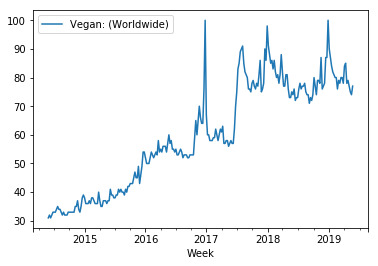

In [15]:
vegan.plot()

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
decomposition = seasonal_decompose(vegan, freq=52, model='multiplicative')

In [29]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

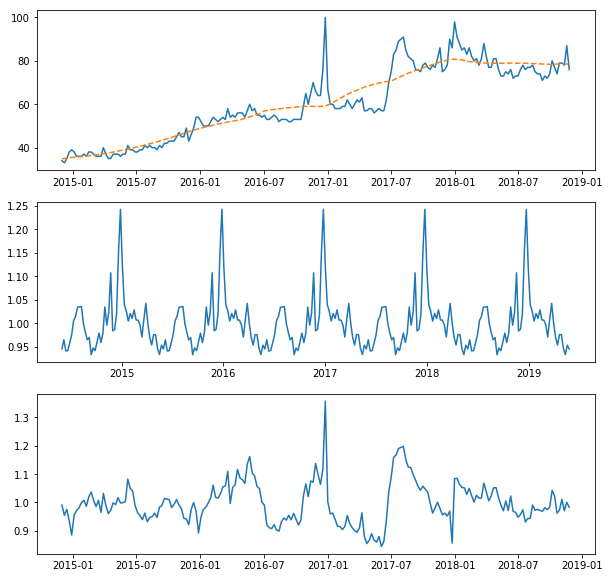

In [30]:
plt.figure(figsize=(10,10))

plt.figure(1)
plt.subplot(311)
plt.plot(trend*seasonal*residual, label='Original')
plt.plot(trend, label='Trend', linestyle='--')
plt.subplot(312)
plt.plot(seasonal, label='Seasonality')
plt.subplot(313)
plt.plot(residual, label='Randomness')



#### ARIMA(p,d,q) Model becomes ARIMA (3,1,1) Model

In [23]:
# p = how many sequential times outside significance shade
# d = how many times do we differentiate (lag)
# q = how many times outside significance shade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

(0, 50)

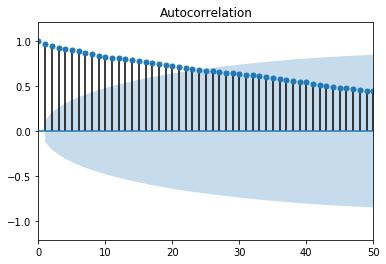

In [24]:
# autocorrelation function drops slowly so there is high degree of autocorrelation i.e. trend in the data and we need to get rid of 
plot_acf(vegan)
plt.xlim(0,50)

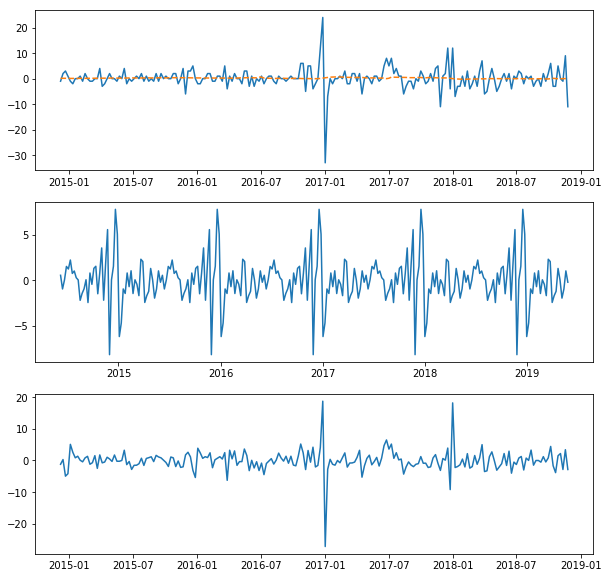

In [27]:
diff = vegan.diff(1).dropna()

decomposition = seasonal_decompose(diff, freq=52, model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))

plt.figure(1)
plt.subplot(311)
plt.plot(trend+seasonal+residual, label='Original')
plt.plot(trend, label='Trend', linestyle='--')
plt.subplot(312)
plt.plot(seasonal, label='Seasonality')
plt.subplot(313)
plt.plot(residual, label='Randomness')



(0, 10)

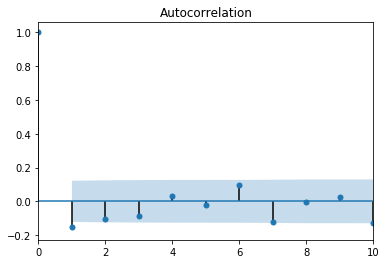

In [31]:
# first value is outside the insignificance area so the p=1 in model. if we see more 
plot_acf(diff)
plt.xlim(0,10)

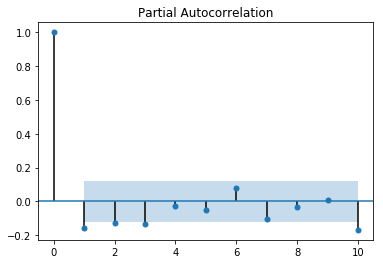

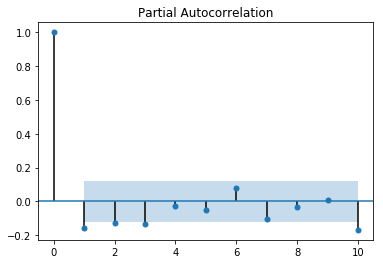

In [33]:
# partial autocorrelation function gets rid of autocorrelation between each day
# 10th number is significant so indicates some seasonality
plot_pacf(diff, lags=10)

#### ARIMA(3,1,1) Model

In [35]:
train = vegan[:'06-2018'].dropna()
test = vegan['06-2018':].dropna()

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [37]:
model = SARIMAX(train, order=(3,1,1), seasonal_order=(1,1,0,52),
               enforce_stationarity=False, enforce_invertibility=False
               )

T:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [38]:
results = model.fit()

In [39]:
prediction = results.predict(start='06-2018', end='06-2019')[1:]

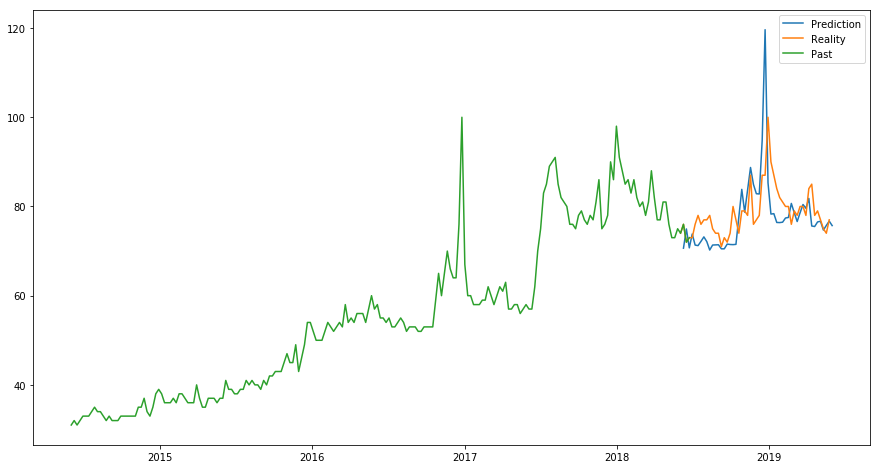

In [42]:
plt.figure(figsize=(15,8))
plt.plot(prediction, label='Prediction')
plt.plot(test, label='Reality')
plt.plot(train, label='Past')
plt.legend(loc='best')

In [43]:
# AIC is important - lower the better. higher bound is infinite.
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                 Vegan: (Worldwide)   No. Observations:                  213
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 52)   Log Likelihood                -321.954
Date:                            Fri, 31 May 2019   AIC                            655.908
Time:                                    10:38:22   BIC                            671.832
Sample:                                06-01-2014   HQIC                           662.361
                                     - 06-24-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1043      3.142     -0.033      0.974      -6.262       6.054
ar.L2         -0.1486      0.586     -0.253      0.800      -1.298       1.001
ar.L3         -0.0373      0.513     -0.073      0.942      -1.043       0.969
ma.L1         -0.0889      3.146     -0.028      0.977      -6.255       6.077
ar.S.L52      -1.0297      0.081    -12.714      0.000      -1.188      -0.871
sigma2        26.9654      2.005     13.448      0.000      23.035      30.895
===================================================================================
Ljung-Box (Q):                       11.85   Jarque-Bera (JB):               357.17
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.19
Prob(H) (two-sided):                  0.01   Kurtosis:                        12.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""